In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_colwidth', None)


### Load Data

In [4]:
issues = pd.read_csv('./csv/greenkeeper_issues.csv')
comments = pd.read_csv('./csv/greenkeeper_comments.csv')
events = pd.read_csv('./csv/greenkeeper_events.csv')
commits = pd.read_csv('./csv/greenkeeper_commits.csv')
package_names = pd.read_csv('./csv/greenkeeper_package_names.csv')

/Users/BenRombaut/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (14,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Custome Helper Functions

In [ ]:
def get_issue(id):
    return issues[issues['issue_id'] == id]

def get_comment(id):
    return comments[comments['comment_id'] == id]

def get_comments_for_issue(id):
    return comments[comments['comment_issue_id'] == id]

def calculate_percent(numer, denom):
    return round((numer/denom)*100, 2)

#### Augment Data

Catoegorize Columns

In [65]:
events['event_description'] = events['event_description'].astype('category')

Create issue_first_comment frame

In [18]:
## This could take a few minutes
def get_first_comment(issue):
    issue_comments = get_comments_for_issue()
    if issue_comments.empty:
        return None
    first_comment = issue_comments[issue_comments['comment_id'] == issue_comments['comment_id'].min()]
    first_comment
    return first_comment['comment_id'].values[0].astype(np.int64)

issue_first_comment = pd.DataFrame({
    'issue_id': issues.issue_id, 
    'comment_id': issues.apply(lambda row: get_first_comment(row), axis=1),
})


`

### How often are Greenkeeper Build Breakage Issue Reports closed?

In [63]:
n_issues = len(issues)
n_closed_issues = len(issues[issues.issue_state == "closed"])
percent_closed = calculate_percent(n_closed_issues, n_issues)
print(f"{percent_closed}% of Greenkeeper issues are eventually closed")

79.82% of Greenkeeper issues are eventually closed


### How much time do Greenkeeper issues take to be closed?

In [102]:
closed_issues = issues[issues["issue_state"] == "closed"]
def calculate_time_diff(issue):
    d1 = issue.issue_created_at
    d2 = issue.issue_closed_at
    FMT = '%Y-%m-%dT%H:%M:%S%z'
    return (datetime.strptime(d2, FMT) - datetime.strptime(d1, FMT))

time_to_close_issue = pd.DataFrame({
    'issue_id': closed_issues.issue_id, 
    'time_to_close_issue': closed_issues.apply(lambda row: calculate_time_diff(row), axis=1),
})

median_time = time_to_close_issue['time_to_close_issue'].median()
print(f"The median time to close the issue is {median_time} hours")


The median time to close the issue is 4 days 11:04:25 hours


In [105]:
print("Five number summary for the time to close the Greenkeeper issue:")
print(time_to_close_issue['time_to_close_issue'].describe())

Five number summary for the time to close the Greenkeeper issue:
count                      98341
mean     43 days 04:48:28.851343
std      98 days 22:44:48.052636
min              0 days 00:00:04
25%              0 days 09:58:19
50%              4 days 11:04:25
75%             35 days 07:48:16
max           1219 days 02:01:10
Name: time_to_close_issue, dtype: object


[None]

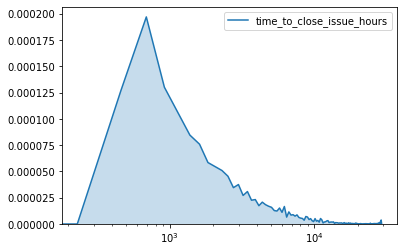

In [163]:
time_to_close_issue['time_to_close_issue_hours'] = \
    (time_to_close_issue['time_to_close_issue'].astype('timedelta64[s]')) / 60 / 60

# TODO: Figure out this graph!

# time_to_close_issue['time_to_close_issue_hours']
# ax = sns.kdeplot(
#     time_to_close_issue['time_to_close_issue_hours'],
#     shade=True,
#     bw=.01,
# )
# ax. set(xscale="log")
# ax = sns.violinplot(
#     data=time_to_close_issue,
#     y="time_to_close_issue_hours"
# )
# ax.set(yscale="symlog")
# ax = sns.distplot(time_to_close_issue["time_to_close_issue_hours"])
# ax.set(xscale="log")

### How many comments do Greenkeeper Breaking Issues have? How many of these are from Greenkeeper?

In [61]:
print("Five number summary for the number of comments on Greenkeeper Breakage issues:")
print(issues["issue_num_comments"].describe())

comments_by_greenkeeper = comments[(comments['comment_user_type'] == "Bot") & comments['comment_user_login'].str.contains("greenkeeper")]
percent_comments_by_greenkeeper = calculate_percent(len(comments_by_greenkeeper), len(comments))
print(f"{percent_comments_by_greenkeeper}% of comments on breaking issue reports opened by Greenkeeper are from the Greenkeeper bot.")



Five number summary for the number of comments on Greenkeeper Breakage issues:
count    123197.000000
mean          4.775555
std          29.850343
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        2500.000000
Name: issue_num_comments, dtype: float64
96.89% of comments on breaking issue reports opened by Greenkeeper are from the Greenkeeper bot.


### How successful is pinning the dependency?

In [38]:
## This might take a few minutes

pin_fail_string = "your tests are still failing"
pin_success_string = "your tests are passing again"

def pin_was_successful(issue_first_comment):
    if pd.isna(issue_first_comment['comment_id']):
        return False
    comment = comments[comments['comment_id'] == issue_first_comment['comment_id']]
    return comment['comment_body'].str.contains(pin_success_string, na=False).values[0]

issue_first_comment['successful_pin'] = \
    issue_first_comment.apply(lambda row: pin_was_successful(row), axis=1)

,issue_id,comment_id,successful_pin
0,629403739,NaN,False
1,628090144,636566644.0,False
2,628092207,636567357.0,False
3,628091232,636566725.0,False
4,629137696,637488315.0,False


In [42]:
succ_pin_count = len(issue_first_comment[issue_first_comment['successful_pin'] == True])
percent_succ_pin_count = calculate_percent(succ_pin_count, len(issue_first_comment))
print(f"{percent_succ_pin_count}% of builds were fixed by pinning the previous update.")

23.76% of builds were fixed by pinning the previous update.


In [54]:
issue_first_comment[issue_first_comment['successful_pin'] == False].head(10)

,issue_id,comment_id,successful_pin
0,629403739,NaN,False
1,628090144,636566644.0,False
2,628092207,636567357.0,False
3,628091232,636566725.0,False
4,629137696,637488315.0,False
5,629018646,NaN,False
6,629195577,NaN,False
7,629402799,NaN,False
8,629190952,NaN,False
9,628093324,636568356.0,False


In [55]:
get_issue(629402799)

,issue_id,issue_number,issue_url,issue_title,issue_state,issue_is_locked,issue_created_at,issue_updated_at,issue_closed_at,issue_user_login,issue_labels,issue_num_comments,issue_events_url,issue_dependency_name,issue_dependency_type,issue_dependency_actual_version,issue_dependency_next_version,issue_dependency_bundle_name,issue_body_parser,issue_repo_url
7,629402799,114,https://api.github.com/repos/environment-agency-austria/react-ocean-forms-bootstrap/issues/114,An in-range update of fortawesome is breaking the build 🚨,open,False,2020-06-02T17:57:17Z,2020-06-02T17:57:18Z,NaN,greenkeeper[bot],[greenkeeper],0,https://api.github.com/repos/environment-agency-austria/react-ocean-forms-bootstrap/issues/114/events,NaN,NaN,NaN,NaN,NaN,NaN,https://api.github.com/repos/environment-agency-austria/react-ocean-forms-bootstrap


In [53]:
get_comments_for_issue(627711937)

,comment_issue_url,comment_issue_id,comment_id,comment_url,comment_created_at,comment_updated_at,comment_body,comment_author_association,comment_user_id,comment_user_login,comment_user_type
87,https://api.github.com/repos/Kronos-Integration/service-http/issues/1046,627711937,636318336,https://api.github.com/repos/Kronos-Integration/service-http/issues/comments/636318336,2020-05-30T11:34:16Z,2020-05-30T11:34:16Z,After pinning to **2.0.12** your tests are passing again. [Downgrade this dependency 📌](https://github.com/Kronos-Integration/service-http/compare/master...Kronos-Integration:greenkeeper%2Fmulti-path-matcher-pin-2.0.12).,CONTRIBUTOR,23040076,greenkeeper[bot],Bot
88,https://api.github.com/repos/Kronos-Integration/service-http/issues/1046,627711937,636318956,https://api.github.com/repos/Kronos-Integration/service-http/issues/comments/636318956,2020-05-30T11:39:44Z,2020-05-30T11:39:44Z,"- The `dependency` [multi-path-matcher](https://github.com/arlac77/multi-path-matcher) was updated from `2.0.13` to `2.0.14`.\n\n\nYour tests are passing again with this update. [Explicitly upgrade to this version 🚀](https://github.com/Kronos-Integration/service-http/compare/master...Kronos-Integration:greenkeeper%2Fmulti-path-matcher-2.0.14)\n\n\n\n<details>\n<summary>Release Notes for v2.0.14</summary>\n\n<h2><a href=""https://urls.greenkeeper.io/arlac77/multi-path-matcher/compare/v2.0.13...v2.0.14"">2.0.14</a> (2020-05-30)</h2>\n<h3>Bug Fixes</h3>\n<ul>\n<li>use relative exports (<a href=""https://urls.greenkeeper.io/arlac77/multi-path-matcher/commit/70c78f1780e16d1493d8cc04ff821e967c462986"">70c78f1</a>)</li>\n</ul>\n</details>\n\n<details>\n<summary>Commits</summary>\n<p>The new version differs by 1 commits.</p>\n<ul>\n<li><a href=""https://urls.greenkeeper.io/arlac77/multi-path-matcher/commit/70c78f1780e16d1493d8cc04ff821e967c462986""><code>70c78f1</code></a> <code>fix: use relative exports</code></li>\n</ul>\n<p>See the <a href=""https://urls.greenkeeper.io/arlac77/multi-path-matcher/compare/a37786fa4eab506ef15958a174d5ea9e563b791d...70c78f1780e16d1493d8cc04ff821e967c462986"">full diff</a></p>\n</details>",CONTRIBUTOR,23040076,greenkeeper[bot],Bot


### Comments by users

In [73]:
user_comments = comments[comments['comment_user_type'] == 'User']
issues_with_user_comments = issues[issues['issue_id'].isin(user_comments['comment_issue_id'])]

How long until first user response?

In [80]:
issues_with_user_comments[['issue_url', "issue_id"]].head(10)

,issue_url,issue_id
21,https://api.github.com/repos/cssinjs/caniuse-support/issues/71,629741164
26,https://api.github.com/repos/cssinjs/caniuse-support/issues/70,628799957
34,https://api.github.com/repos/cerner/carbon-graphs/issues/223,628100727
42,https://api.github.com/repos/atlassian/stricter/issues/121,628604170
44,https://api.github.com/repos/cerner/carbon-graphs/issues/226,628657186
72,https://api.github.com/repos/cssinjs/css-vendor/issues/209,627843386
106,https://api.github.com/repos/cerner/carbon-graphs/issues/221,627134159
194,https://api.github.com/repos/Mermade/oas-kit/issues/231,625292166
213,https://api.github.com/repos/cerner/carbon-graphs/issues/218,625315492
240,https://api.github.com/repos/johnpapa/vscode-peacock/issues/396,625109277


In [84]:
issue_id = 629741164

events[events['event_issue_id'] == issue_id]


,event_issue_url,event_issue_id,event_id,event_url,event_created_at,event_description,event_actor_id,event_actor_login,event_commit_id,event_commit_url,event_label
25,https://api.github.com/repos/cssinjs/caniuse-support/issues/71,629741164,3400682154,https://api.github.com/repos/cssinjs/caniuse-support/issues/events/3400682154,2020-06-03T06:53:03Z,labeled,23040076.0,greenkeeper[bot],NaN,NaN,greenkeeper
26,https://api.github.com/repos/cssinjs/caniuse-support/issues/71,629741164,3604755981,https://api.github.com/repos/cssinjs/caniuse-support/issues/events/3604755981,2020-07-30T16:33:52Z,closed,1459899.0,AleshaOleg,NaN,NaN,NaN


In [85]:
get_comments_for_issue(issue_id)

,comment_issue_url,comment_issue_id,comment_id,comment_url,comment_created_at,comment_updated_at,comment_body,comment_author_association,comment_user_id,comment_user_login,comment_user_type
19,https://api.github.com/repos/cssinjs/caniuse-support/issues/71,629741164,637996706,https://api.github.com/repos/cssinjs/caniuse-support/issues/comments/637996706,2020-06-03T06:54:19Z,2020-06-03T06:54:19Z,After pinning to **1.3.0** your tests are still failing. The reported issue _might_ not affect your project. These imprecisions are caused by inconsistent test results.,CONTRIBUTOR,23040076,greenkeeper[bot],Bot
20,https://api.github.com/repos/cssinjs/caniuse-support/issues/71,629741164,638021467,https://api.github.com/repos/cssinjs/caniuse-support/issues/comments/638021467,2020-06-03T07:42:43Z,2020-06-03T07:42:43Z,"- The `devDependency` [merge2](https://github.com/teambition/merge2) was updated from `1.4.0` to `1.4.1`.\n\n\nYour tests are passing again with this update. [Explicitly upgrade to this version 🚀](https://github.com/cssinjs/caniuse-support/compare/master...cssinjs:greenkeeper%2Fmerge2-1.4.1)\n\n\n\n<details>\n<summary>Commits</summary>\n<p>The new version differs by 1 commits.</p>\n<ul>\n<li><a href=""https://urls.greenkeeper.io/teambition/merge2/commit/a7300d42983d668f61d751ad2bfc42c880a29a36""><code>a7300d4</code></a> <code>Fixed: remove error listener on end.</code></li>\n</ul>\n<p>See the <a href=""https://urls.greenkeeper.io/teambition/merge2/compare/5dc3ea60a18feed7fd26f29ec2f06ddb89bf88cd...a7300d42983d668f61d751ad2bfc42c880a29a36"">full diff</a></p>\n</details>",CONTRIBUTOR,23040076,greenkeeper[bot],Bot
21,https://api.github.com/repos/cssinjs/caniuse-support/issues/71,629741164,666510646,https://api.github.com/repos/cssinjs/caniuse-support/issues/comments/666510646,2020-07-30T16:33:52Z,2020-07-30T16:33:52Z,https://github.com/cssinjs/caniuse-support/pull/73,MEMBER,1459899,AleshaOleg,User
